### Process
Two choices:
1. Loop through files and create bigger files, more close to HMP data format in xArray files
OR:
1. Create a DataLoader that loops through remaining files, loads it in, checks if it fits (has the correct channels), then trains using that file
This approach would mean that files that are unfit are re-checked every time, instead of just doing another pass over the data and saving only those that are fit for data. Could also create a subset of the paths for all files that are fit, then we wouldn't have to re-check

In [1]:
import glob
from pathlib import Path
import pyedflib
from hmpai.pytorch.generators import TUEGDataset
import pandas as pd
import numpy as np
import multiprocessing
import os
from tqdm.notebook import tqdm
import ast

In [2]:
# Load tracker
edf_tracker = pd.read_csv('edf_tracker.csv')

# (TUEG > SAT2)
electrode_mapping = {
    'EEG FP1': 'Fp1',
    'EEG FP2': 'Fp2',
    'EEG F7': 'F7',
    'EEG F8': 'F8',
    'EEG F3': 'F3',
    'EEG F4': 'F4',
    'EEG FZ': 'Fz',
    'EEG T3': 'T7',  # T3 corresponds to T7
    'EEG T4': 'T8',  # T4 corresponds to T8
    'EEG C3': 'C3',
    'EEG C4': 'C4',
    'EEG CZ': 'Cz',
    'EEG T5': 'P7',  # T5 corresponds to P7
    'EEG T6': 'P8',  # T6 corresponds to P8
    'EEG P3': 'P3',
    'EEG P4': 'P4',
    'EEG PZ': 'Pz',
    'EEG O1': 'O1',
    'EEG O2': 'O2'
}

# https://stackoverflow.com/questions/40357434/pandas-df-iterrows-parallelization
def parallelize_dataframe(df, func, num_cores=None):
    num_cores = multiprocessing.cpu_count() - 1 if num_cores is None else num_cores  #leave one free to not freeze machine
    num_partitions = num_cores #number of partitions to split dataframe
    df_split = np.array_split(df, num_partitions)
    pool = multiprocessing.Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


### Gather all file paths in TUEG dataset

In [ ]:
# Write filenames to file so we dont need to search through folder structure
path = Path("../../data/tueg")

files = path.rglob("*.edf")

with open('edf_files.txt', 'w') as file:
    for f_name in files:
        file.write(str(f_name) + "\n")

In [ ]:
# Assumes files are already gathered in edf_files.txt
with open('edf_files.txt', 'r') as file:
    files = file.readlines()

### Save .edf file paths and metadata in .csv file

In [ ]:
# Create new empty dataframe to keep track of edf processing
data = pd.DataFrame(files, columns=['path'])
data.path = data.path.str.rstrip('\n')
data['filename'] = data.path.str.split('/').str[-1]
# Whether the file has been processed
data['processed'] = False
# What the sampling frequency is that was found
data['frequency'] = -1
# Which channels are included
data['channels'] = None
data['channels'] = data['channels'].astype(str)
# Whether a match was found in channel configurations
data['match'] = False
data.to_csv('edf_tracker_empty.csv', index=False)

In [6]:
# Takes ~3.5 minutes
def process_metadata_chunk(chunk):
    for idx, row in chunk.iterrows():
        if row.processed:
            continue
        edf = pyedflib.EdfReader(row['path'])
        freq = edf.getSampleFrequency(0)
        channels = edf.getSignalLabels()
        chunk.loc[idx, 'frequency'] = freq
        chunk.loc[idx, 'channels'] = str(channels)
    return chunk


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
new_edf_tracker = parallelize_dataframe(edf_tracker, process_metadata_chunk)

In [8]:
new_edf_tracker.to_csv('edf_tracker.csv', index=False)

### Check if match

In [3]:
# Process a part of the edf_tracker dataframe
def process_match_chunk(chunk):
    for idx, row in chunk.iterrows():
        if row.processed:
            continue
        electrode_present = {key: False for key in electrode_mapping.keys()}
        ch_list = ast.literal_eval(row.channels)
        for ch in ch_list:
            ch_name = ch.split('-')[0]
            if ch_name in electrode_mapping:
                electrode_present[ch_name] = True
        # All electrodes are present
        if all(electrode_present.values()):
            chunk.loc[idx, 'match'] = True
    return chunk


In [27]:
new_edf_tracker = parallelize_dataframe(edf_tracker, process_match_chunk)
new_edf_tracker.to_csv('edf_tracker.csv', index=False)

### Split files

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns
CHUNK_SIZE = 150
FILE_SIZE = 1000
PATH_BASE = Path("../../data/tueg_split")
def process_split_chunk(chunk):
    for idx, row in chunk.iterrows():
        # List to keep (N, 100) samples where N = num_channels
        if row.processed or not row.match:
            continue
        edf = pyedflib.EdfReader(row.path)
        ch_list = ast.literal_eval(row.channels)
        n_ch = len(electrode_mapping)
        n_buf = edf.getNSamples()[0]
        # Create big signals ndarray
        signals = np.zeros((n_ch, n_buf))
        electrodes = list(electrode_mapping.keys())
        for ch_idx, ch in enumerate(ch_list):
            ch_name = ch.split('-')[0]
            # Save index in edf file
            if ch_name in electrode_mapping:
                signals[electrodes.index(ch_name), :] = edf.readSignal(ch_idx, n=n_buf)
        edf.close()
        n_chunks = n_buf // CHUNK_SIZE

        # If LE, average reference
        if 'tcp_le' in row.path:
            ch_mean = np.mean(signals, axis=0)
            signals = signals - ch_mean
        
        # Truncate to divide by CHUNK_SIZE
        signals = signals[:, :n_chunks * CHUNK_SIZE]

        sns.lineplot(signals[0, :])
        plt.show()
        # Split time dimensions into chunks of size CHUNK_SIZE
        signals = signals.reshape(-1, n_ch, CHUNK_SIZE)

        # Remove entries with values that fall outside the 5th and 95th percentile bound
        lower_bound = np.percentile(signals, 10)
        upper_bound = np.percentile(signals, 90)
        mask = (signals >= lower_bound) & (signals <= upper_bound)
        valid_entries_mask = np.all(mask, axis=(1, 2))
        sns.scatterplot(valid_entries_mask)
        plt.show()

        filtered_signals = signals[valid_entries_mask]
        print(signals.shape, filtered_signals.shape)

        # Reorder channels dim
        # ch_indices = list(electrode_idx_mapping.values())
        # filtered_signals = filtered_signals[ch_indices]

        # Normalize over valid signals to [-1, 1], loses amplitude information compared to rest of data
        min_val = filtered_signals.min()
        max_val = filtered_signals.max()
        filtered_signals = 2 * (filtered_signals - min_val) / (max_val - min_val) - 1

        # Split filtered_signals up into chunks of 1000 and save this and remainder to disk
        num_chunks = (filtered_signals.shape[0] + FILE_SIZE - 1) // FILE_SIZE
        for i in range(num_chunks):
            start_idx = i * CHUNK_SIZE
            end_idx = min((i + 1) * CHUNK_SIZE, filtered_signals.shape[0])
            chunk = filtered_signals[start_idx:end_idx]
            filename = PATH_BASE / f"{row.path.split('edf/')[1].replace('/', '_')[:-4]}_chunk_{i}.npy"
            print(filename)

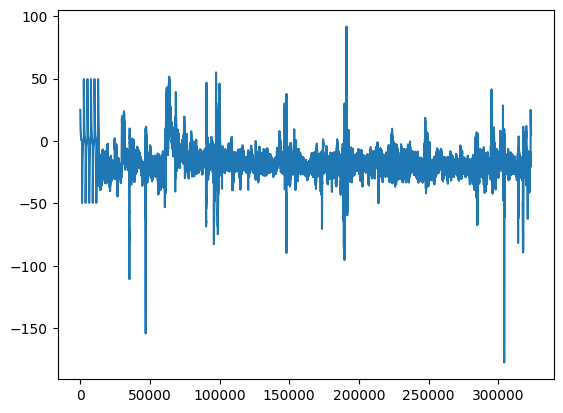

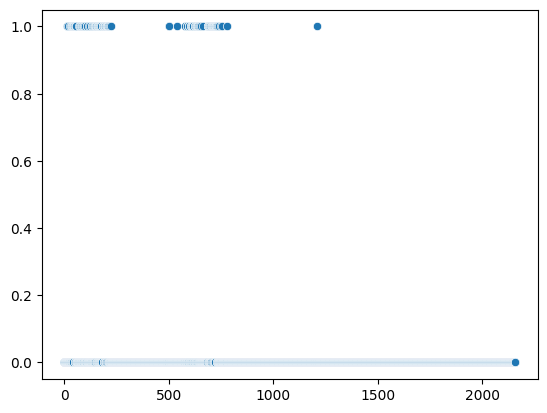

(2158, 19, 150) (136, 19, 150)
../../data/tueg_split/000_aaaaaaaa_s001_2015_01_tcp_ar_aaaaaaaa_s001_t000_chunk_0.npy


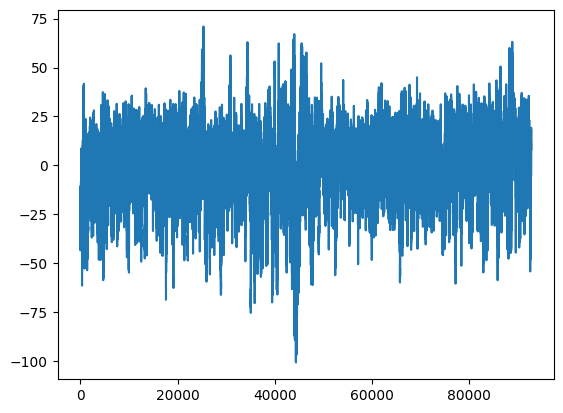

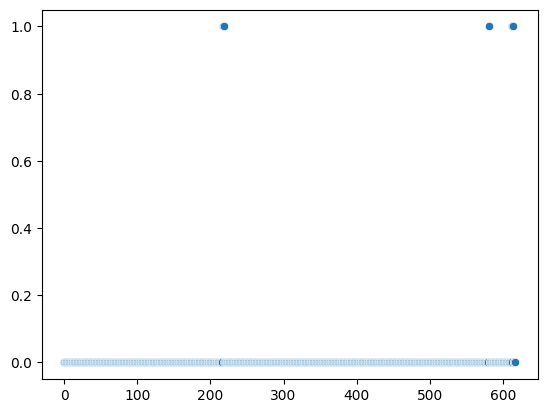

(618, 19, 150) (5, 19, 150)
../../data/tueg_split/000_aaaaaaab_s001_2002_02_tcp_le_aaaaaaab_s001_t000_chunk_0.npy


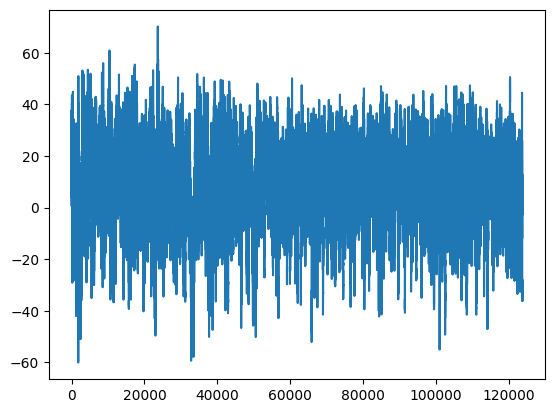

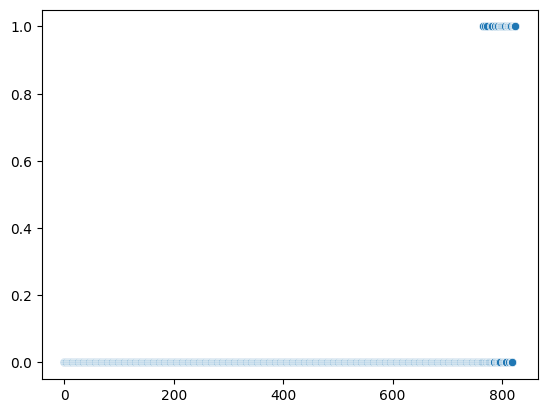

(825, 19, 150) (28, 19, 150)
../../data/tueg_split/000_aaaaaaab_s001_2002_02_tcp_le_aaaaaaab_s001_t001_chunk_0.npy


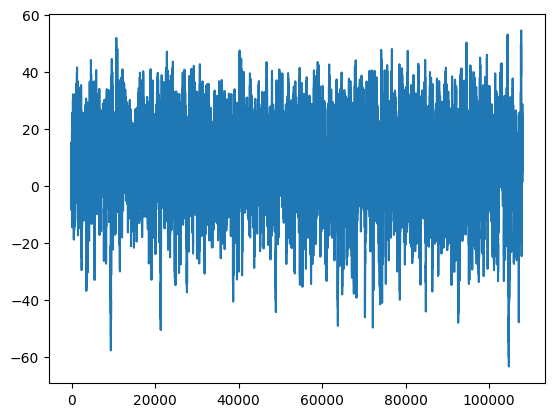

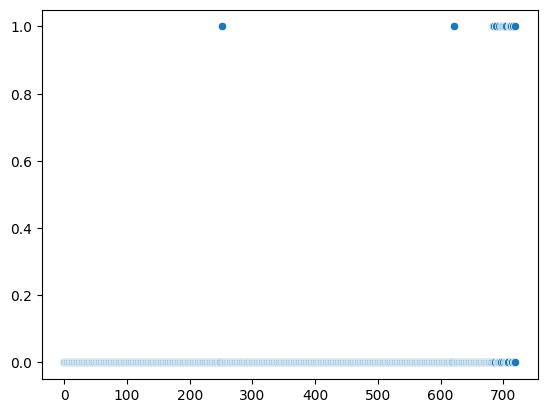

(720, 19, 150) (20, 19, 150)
../../data/tueg_split/000_aaaaaaab_s001_2002_02_tcp_le_aaaaaaab_s001_t003_chunk_0.npy


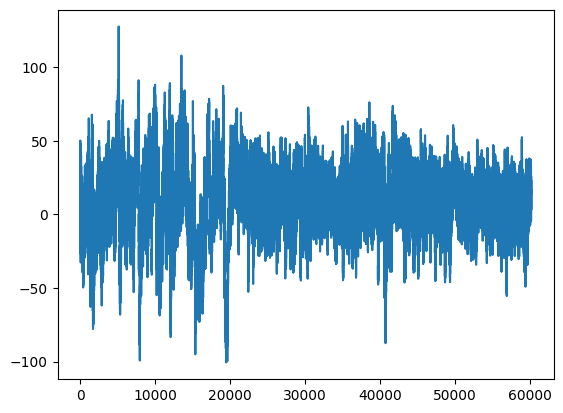

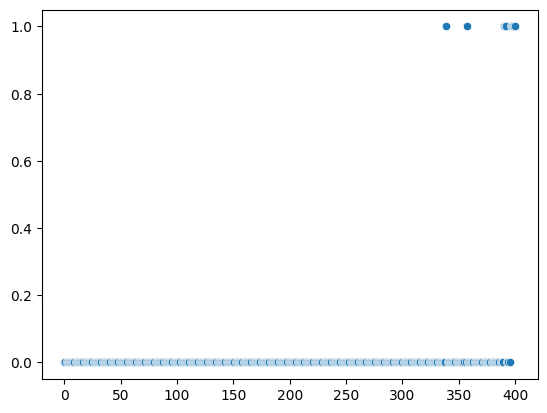

(401, 19, 150) (10, 19, 150)
../../data/tueg_split/000_aaaaaaab_s001_2002_02_tcp_le_aaaaaaab_s001_t004_chunk_0.npy


In [223]:
sig = process_split_chunk(edf_tracker[:5])

In [205]:
sig[0]

TypeError: 'NoneType' object is not subscriptable

In [154]:
sig[0].shape

(1235, 31, 150)

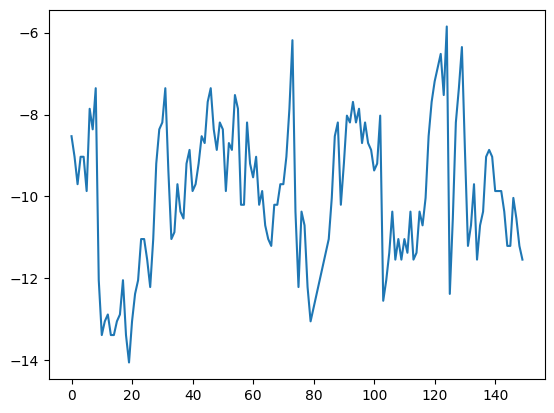

In [161]:
plt.plot(sig[0][3,0,:])

In [65]:
no_eeg = sig[:,:150]
yes_eeg = sig[:,14000:1450]

In [101]:
np.percentile(sig[0,:], 5)

-30.112004516739947

In [100]:
np.percentile(sig[0,:], 95)

1.175177953428209

-18.56753611865651

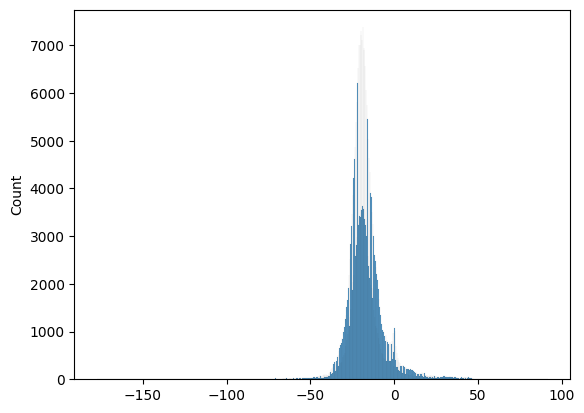

In [93]:
sns.histplot(sig[0,:])
np.median(sig[0,:])

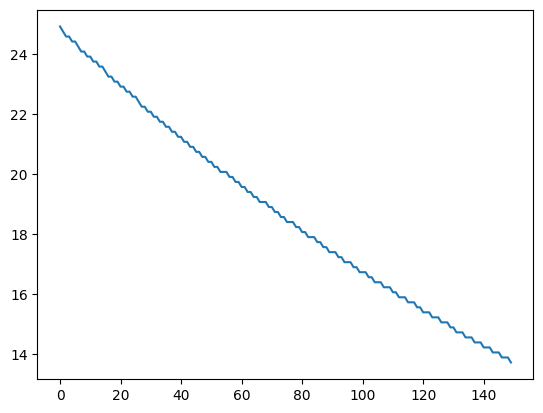

In [87]:
plt.plot(sig[1,:150])

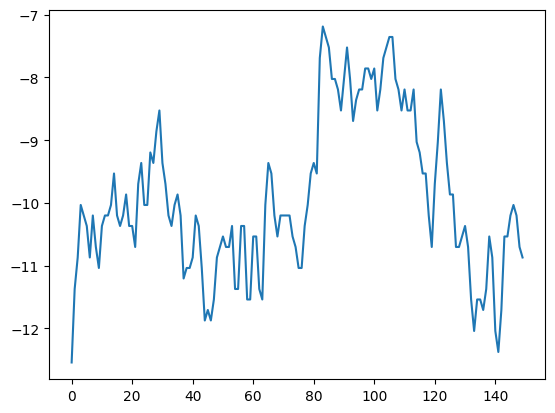

In [94]:
plt.plot(sig[1,14000:14150])

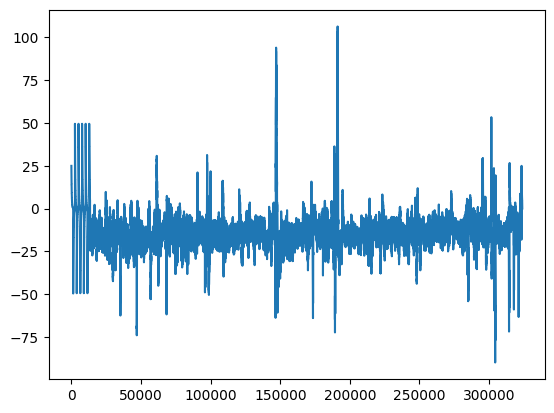

In [51]:
plt.plot(sig[1,0:])

In [ ]:
# Only look for files with sampling frequency of 250
FREQ = 250
with open('edf_files.txt', 'r') as file:
    files = file.readlines()
prev_channels = []
for file in files:
    file = file.rstrip("\n")
    # print(file)
    edf = pyedflib.EdfReader(file)

    # Skip if not FREQ sampling frequency, TODO: Maybe resample to 250? SAT2 250 might also be 256, should be 250 though
    # Could resample using  raw = mne.io.RawArray(data.T, info), then resample using raw.resample(sfreq) https://mne.tools/dev/generated/mne.io.Raw.html#mne.io.Raw.resample
    # Or just use scipy.signal.resample https://docs.scipy.org/doc/scipy-1.12.0/reference/generated/scipy.signal.resample.html
    file_freq = edf.getSampleFrequency(0)
    if file_freq != FREQ:
        continue
    # is AR always 256 instead of 250?
    # _le is auricular-referenced
    # _ar is average-referenced (goal)
    # re-reference le to ar?

    # Split into multiple smaller files or save until 1000 samples are reached, then save?
    channels = edf.getSignalLabels()
    # Check if all needed 10-20 channels are included
    # SAT2
    # ['Fp1', 'Fp2', 'AFz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz',
    #    'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2', 'FC1', 'FCz',
    #    'FC2', 'FC5', 'FC6', 'CP5', 'CP1', 'CPz', 'CP2', 'CP6']
    


NameError: name 'pyedflib' is not defined